# 🎯 4단계: 하이퍼파라미터 최적화

## 📋 목표
- GridSearchCV를 통한 최적 파라미터 탐색
- RandomizedSearchCV 비교
- 학습 곡선 및 검증 곡선 분석
- 교차검증을 통한 더 정확한 성능 평가

## 📊 분석 내용
1. GridSearchCV를 통한 Ridge/Lasso 최적화
2. RandomizedSearchCV 성능 비교
3. 교차검증 점수 분석
4. 학습 곡선(Learning Curve) 분석
5. 검증 곡선(Validation Curve) 분석
6. 최종 모델 선택 및 성능 평가

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, learning_curve, validation_curve
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from font_setup import setup_korean_font
setup_korean_font()

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")

✅ 한글 폰트 설정 완료: Malgun Gothic


## 1️⃣ 데이터 준비 및 파이프라인 설정

In [2]:
# 데이터 로드
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target
feature_names = california_housing.feature_names

print("📊 California Housing Dataset 정보")
print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")
print(f"특성 이름: {list(feature_names)}")

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 데이터 분할 결과")
print(f"훈련 데이터: {X_train.shape[0]}개 샘플")
print(f"테스트 데이터: {X_test.shape[0]}개 샘플")

📊 California Housing Dataset 정보
특성 수: 8
샘플 수: 20640
특성 이름: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

📊 데이터 분할 결과
훈련 데이터: 16512개 샘플
테스트 데이터: 4128개 샘플


In [3]:
# 파이프라인 설정 (정규화 + 모델)
def create_pipeline(model):
    """
    StandardScaler + 모델 파이프라인 생성
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# 기본 모델들
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=2000)
}

print("🔧 파이프라인 설정 완료")
print("• StandardScaler + 모델 파이프라인")
print("• 교차검증을 통한 하이퍼파라미터 최적화")

🔧 파이프라인 설정 완료
• StandardScaler + 모델 파이프라인
• 교차검증을 통한 하이퍼파라미터 최적화


## 2️⃣ GridSearchCV를 통한 하이퍼파라미터 최적화

In [4]:
# Ridge GridSearchCV
print("🔍 Ridge Regression GridSearchCV 시작...")
start_time = time.time()

ridge_pipeline = create_pipeline(Ridge(random_state=42))
ridge_param_grid = {
    'model__alpha': np.logspace(-3, 3, 50)  # 0.001 ~ 1000 범위에서 50개 값
}

ridge_grid = GridSearchCV(
    ridge_pipeline, 
    ridge_param_grid, 
    cv=5,  # 5-fold 교차검증
    scoring='r2',
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=1
)

ridge_grid.fit(X_train, y_train)
ridge_time = time.time() - start_time

print(f"✅ Ridge GridSearchCV 완료 (소요시간: {ridge_time:.2f}초)")
print(f"🎯 최적 Ridge α: {ridge_grid.best_params_['model__alpha']:.4f}")
print(f"📊 최적 CV Score: {ridge_grid.best_score_:.4f}")

🔍 Ridge Regression GridSearchCV 시작...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Ridge GridSearchCV 완료 (소요시간: 8.11초)
🎯 최적 Ridge α: 0.0010
📊 최적 CV Score: 0.6115


In [5]:
# Lasso GridSearchCV
print("\n🔍 Lasso Regression GridSearchCV 시작...")
start_time = time.time()

lasso_pipeline = create_pipeline(Lasso(random_state=42, max_iter=2000))
lasso_param_grid = {
    'model__alpha': np.logspace(-4, 1, 50)  # 0.0001 ~ 10 범위에서 50개 값
}

lasso_grid = GridSearchCV(
    lasso_pipeline, 
    lasso_param_grid, 
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

lasso_grid.fit(X_train, y_train)
lasso_time = time.time() - start_time

print(f"✅ Lasso GridSearchCV 완료 (소요시간: {lasso_time:.2f}초)")
print(f"🎯 최적 Lasso α: {lasso_grid.best_params_['model__alpha']:.4f}")
print(f"📊 최적 CV Score: {lasso_grid.best_score_:.4f}")


🔍 Lasso Regression GridSearchCV 시작...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Lasso GridSearchCV 완료 (소요시간: 1.68초)
🎯 최적 Lasso α: 0.0005
📊 최적 CV Score: 0.6115


In [6]:
# 기본 Linear Regression 교차검증 점수
linear_pipeline = create_pipeline(LinearRegression())
linear_cv_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='r2')
linear_cv_mean = linear_cv_scores.mean()

print(f"\n📊 교차검증 결과 비교")
print("=" * 50)
print(f"Linear Regression CV Score: {linear_cv_mean:.4f} (±{linear_cv_scores.std()*2:.4f})")
print(f"Ridge (최적) CV Score: {ridge_grid.best_score_:.4f}")
print(f"Lasso (최적) CV Score: {lasso_grid.best_score_:.4f}")


📊 교차검증 결과 비교
Linear Regression CV Score: 0.6115 (±0.0129)
Ridge (최적) CV Score: 0.6115
Lasso (최적) CV Score: 0.6115


## 3️⃣ RandomizedSearchCV 비교

In [7]:
# RandomizedSearchCV 비교 (더 넓은 범위에서 빠른 탐색)
print("🎲 RandomizedSearchCV 시작...")

# Ridge RandomizedSearchCV
start_time = time.time()
ridge_random = RandomizedSearchCV(
    ridge_pipeline,
    {'model__alpha': np.logspace(-4, 4, 1000)},  # 더 넓은 범위
    n_iter=100,  # 100번의 랜덤 샘플링
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)
ridge_random.fit(X_train, y_train)
ridge_random_time = time.time() - start_time

# Lasso RandomizedSearchCV
start_time = time.time()
lasso_random = RandomizedSearchCV(
    lasso_pipeline,
    {'model__alpha': np.logspace(-5, 2, 1000)},  # 더 넓은 범위
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)
lasso_random.fit(X_train, y_train)
lasso_random_time = time.time() - start_time

print(f"\n⚡ RandomizedSearchCV 결과")
print("=" * 50)
print(f"Ridge Random - α: {ridge_random.best_params_['model__alpha']:.4f}, Score: {ridge_random.best_score_:.4f} ({ridge_random_time:.1f}초)")
print(f"Ridge Grid   - α: {ridge_grid.best_params_['model__alpha']:.4f}, Score: {ridge_grid.best_score_:.4f} ({ridge_time:.1f}초)")
print(f"\nLasso Random - α: {lasso_random.best_params_['model__alpha']:.4f}, Score: {lasso_random.best_score_:.4f} ({lasso_random_time:.1f}초)")
print(f"Lasso Grid   - α: {lasso_grid.best_params_['model__alpha']:.4f}, Score: {lasso_grid.best_score_:.4f} ({lasso_time:.1f}초)")

🎲 RandomizedSearchCV 시작...

⚡ RandomizedSearchCV 결과
Ridge Random - α: 0.0001, Score: 0.6115 (1.7초)
Ridge Grid   - α: 0.0010, Score: 0.6115 (8.1초)

Lasso Random - α: 0.0004, Score: 0.6115 (3.2초)
Lasso Grid   - α: 0.0005, Score: 0.6115 (1.7초)


## 4️⃣ 검증 곡선 (Validation Curve) 분석

In [8]:
# Ridge 검증 곡선
ridge_alphas = np.logspace(-3, 3, 30)
ridge_train_scores, ridge_val_scores = validation_curve(
    ridge_pipeline, X_train, y_train,
    param_name='model__alpha',
    param_range=ridge_alphas,
    cv=5, scoring='r2', n_jobs=-1
)

# Lasso 검증 곡선
lasso_alphas = np.logspace(-4, 1, 30)
lasso_train_scores, lasso_val_scores = validation_curve(
    lasso_pipeline, X_train, y_train,
    param_name='model__alpha',
    param_range=lasso_alphas,
    cv=5, scoring='r2', n_jobs=-1
)

print("📈 검증 곡선 계산 완료")

📈 검증 곡선 계산 완료


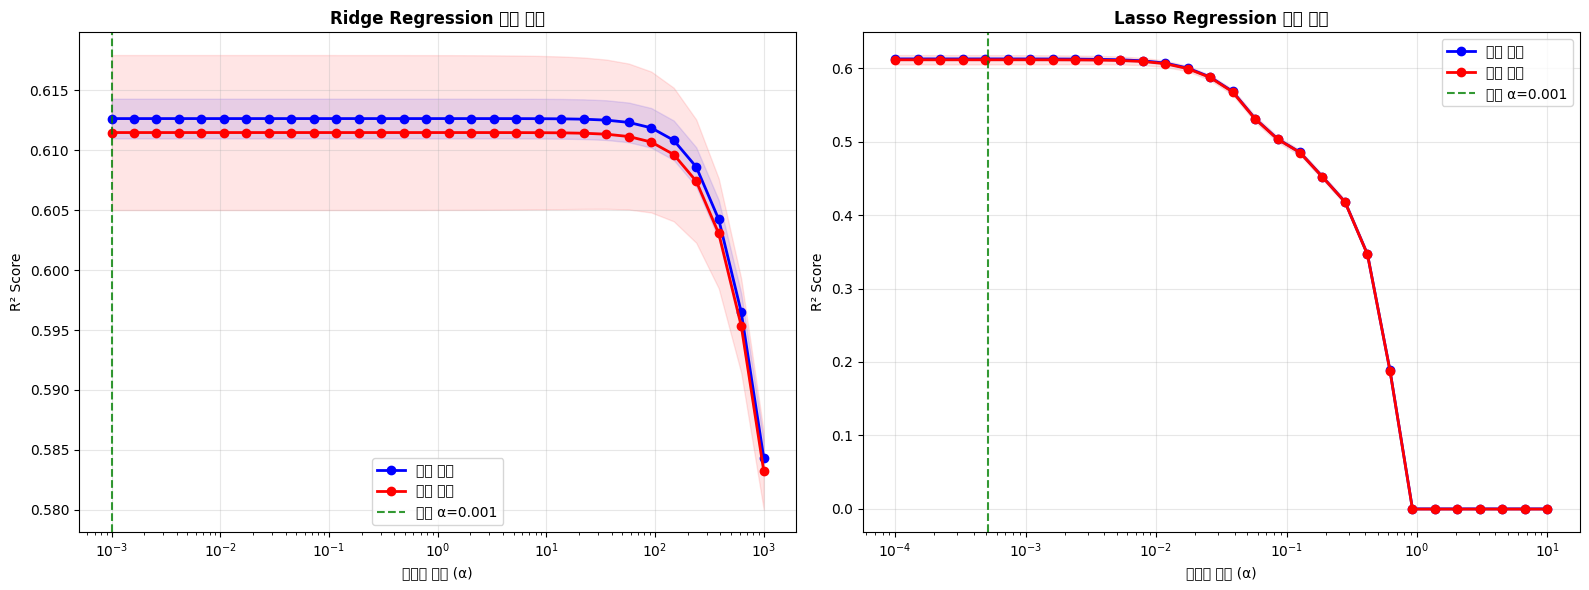

In [9]:
# 검증 곡선 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Ridge 검증 곡선
ridge_train_mean = ridge_train_scores.mean(axis=1)
ridge_train_std = ridge_train_scores.std(axis=1)
ridge_val_mean = ridge_val_scores.mean(axis=1)
ridge_val_std = ridge_val_scores.std(axis=1)

ax1.plot(ridge_alphas, ridge_train_mean, 'o-', color='blue', label='훈련 점수', linewidth=2)
ax1.fill_between(ridge_alphas, ridge_train_mean - ridge_train_std,
                 ridge_train_mean + ridge_train_std, alpha=0.1, color='blue')
ax1.plot(ridge_alphas, ridge_val_mean, 'o-', color='red', label='검증 점수', linewidth=2)
ax1.fill_between(ridge_alphas, ridge_val_mean - ridge_val_std,
                 ridge_val_mean + ridge_val_std, alpha=0.1, color='red')

ax1.axvline(x=ridge_grid.best_params_['model__alpha'], color='green', 
            linestyle='--', alpha=0.8, label=f'최적 α={ridge_grid.best_params_["model__alpha"]:.3f}')
ax1.set_xscale('log')
ax1.set_xlabel('정규화 강도 (α)')
ax1.set_ylabel('R² Score')
ax1.set_title('Ridge Regression 검증 곡선', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lasso 검증 곡선
lasso_train_mean = lasso_train_scores.mean(axis=1)
lasso_train_std = lasso_train_scores.std(axis=1)
lasso_val_mean = lasso_val_scores.mean(axis=1)
lasso_val_std = lasso_val_scores.std(axis=1)

ax2.plot(lasso_alphas, lasso_train_mean, 'o-', color='blue', label='훈련 점수', linewidth=2)
ax2.fill_between(lasso_alphas, lasso_train_mean - lasso_train_std,
                 lasso_train_mean + lasso_train_std, alpha=0.1, color='blue')
ax2.plot(lasso_alphas, lasso_val_mean, 'o-', color='red', label='검증 점수', linewidth=2)
ax2.fill_between(lasso_alphas, lasso_val_mean - lasso_val_std,
                 lasso_val_mean + lasso_val_std, alpha=0.1, color='red')

ax2.axvline(x=lasso_grid.best_params_['model__alpha'], color='green', 
            linestyle='--', alpha=0.8, label=f'최적 α={lasso_grid.best_params_["model__alpha"]:.3f}')
ax2.set_xscale('log')
ax2.set_xlabel('정규화 강도 (α)')
ax2.set_ylabel('R² Score')
ax2.set_title('Lasso Regression 검증 곡선', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ 학습 곡선 (Learning Curve) 분석

In [10]:
# 최적 모델들로 학습 곡선 생성
print("📚 학습 곡선 계산 중...")

# 훈련 세트 크기
train_sizes = np.linspace(0.1, 1.0, 10)

# Linear Regression 학습 곡선
linear_train_sizes, linear_train_scores, linear_val_scores = learning_curve(
    linear_pipeline, X_train, y_train, train_sizes=train_sizes, 
    cv=5, scoring='r2', n_jobs=-1
)

# Ridge (최적) 학습 곡선
ridge_train_sizes, ridge_train_scores_lc, ridge_val_scores_lc = learning_curve(
    ridge_grid.best_estimator_, X_train, y_train, train_sizes=train_sizes, 
    cv=5, scoring='r2', n_jobs=-1
)

# Lasso (최적) 학습 곡선
lasso_train_sizes, lasso_train_scores_lc, lasso_val_scores_lc = learning_curve(
    lasso_grid.best_estimator_, X_train, y_train, train_sizes=train_sizes, 
    cv=5, scoring='r2', n_jobs=-1
)

print("✅ 학습 곡선 계산 완료")

📚 학습 곡선 계산 중...
✅ 학습 곡선 계산 완료


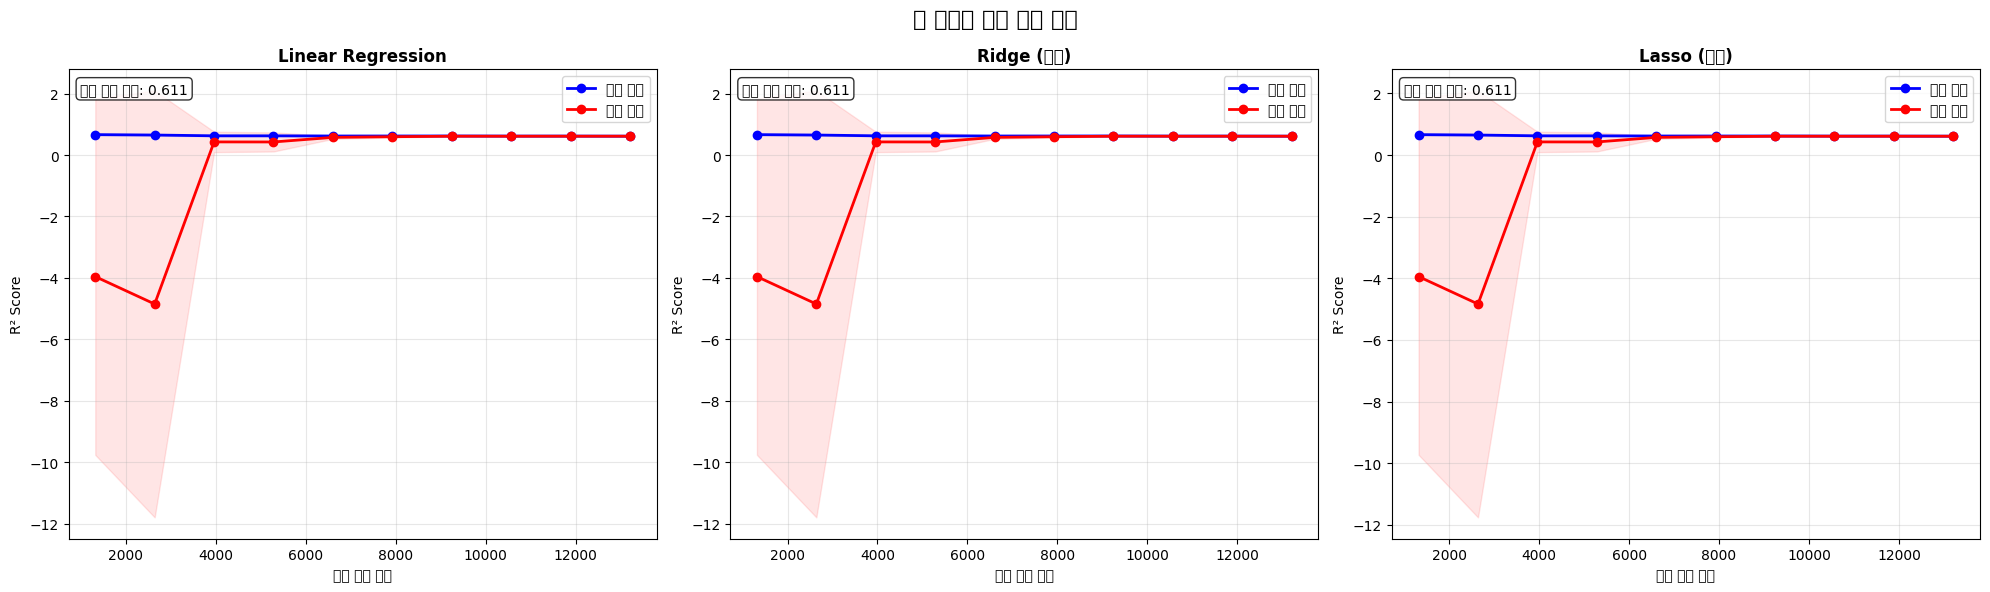

In [11]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('📚 모델별 학습 곡선 비교', fontsize=16, fontweight='bold')

models_lc = [
    ('Linear Regression', linear_train_sizes, linear_train_scores, linear_val_scores),
    ('Ridge (최적)', ridge_train_sizes, ridge_train_scores_lc, ridge_val_scores_lc),
    ('Lasso (최적)', lasso_train_sizes, lasso_train_scores_lc, lasso_val_scores_lc)
]

for i, (name, train_sizes_lc, train_scores_lc, val_scores_lc) in enumerate(models_lc):
    train_mean = train_scores_lc.mean(axis=1)
    train_std = train_scores_lc.std(axis=1)
    val_mean = val_scores_lc.mean(axis=1)
    val_std = val_scores_lc.std(axis=1)
    
    axes[i].plot(train_sizes_lc, train_mean, 'o-', color='blue', 
                 label='훈련 점수', linewidth=2, markersize=6)
    axes[i].fill_between(train_sizes_lc, train_mean - train_std,
                         train_mean + train_std, alpha=0.1, color='blue')
    
    axes[i].plot(train_sizes_lc, val_mean, 'o-', color='red', 
                 label='검증 점수', linewidth=2, markersize=6)
    axes[i].fill_between(train_sizes_lc, val_mean - val_std,
                         val_mean + val_std, alpha=0.1, color='red')
    
    axes[i].set_xlabel('훈련 세트 크기')
    axes[i].set_ylabel('R² Score')
    axes[i].set_title(name, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # 최종 성능 표시
    final_val_score = val_mean[-1]
    axes[i].text(0.02, 0.95, f'최종 검증 점수: {final_val_score:.3f}', 
                transform=axes[i].transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 6️⃣ 최종 모델 성능 평가

In [12]:
# 최적 모델들로 테스트 세트 평가
def evaluate_final_model(model, model_name, X_test, y_test):
    """
    최종 모델 평가 함수
    """
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Predictions': y_pred
    }

# 최적 모델들 평가
linear_pipeline.fit(X_train, y_train)
results_final = {
    'linear': evaluate_final_model(linear_pipeline, 'Linear Regression', X_test, y_test),
    'ridge_grid': evaluate_final_model(ridge_grid.best_estimator_, 
                                      f'Ridge (α={ridge_grid.best_params_["model__alpha"]:.4f})', 
                                      X_test, y_test),
    'lasso_grid': evaluate_final_model(lasso_grid.best_estimator_, 
                                      f'Lasso (α={lasso_grid.best_params_["model__alpha"]:.4f})', 
                                      X_test, y_test),
    'ridge_random': evaluate_final_model(ridge_random.best_estimator_, 
                                         f'Ridge Random (α={ridge_random.best_params_["model__alpha"]:.4f})', 
                                         X_test, y_test),
    'lasso_random': evaluate_final_model(lasso_random.best_estimator_, 
                                         f'Lasso Random (α={lasso_random.best_params_["model__alpha"]:.4f})', 
                                         X_test, y_test)
}

# 결과 표 생성
final_df = pd.DataFrame([
    {
        '모델': results_final[key]['Model'],
        'Test_R²': results_final[key]['R²'],
        'Test_RMSE': results_final[key]['RMSE'],
        'Test_MAE': results_final[key]['MAE']
    }
    for key in results_final.keys()
]).sort_values('Test_R²', ascending=False)

print("🏆 최종 모델 성능 비교 (테스트 세트)")
print("=" * 80)
print(final_df.round(4))

# 최고 성능 모델
best_model = final_df.iloc[0]
print(f"\n🥇 최고 성능 모델: {best_model['모델']}")
print(f"📊 Test R² Score: {best_model['Test_R²']:.4f}")
print(f"📊 Test RMSE: {best_model['Test_RMSE']:.4f}")

🏆 최종 모델 성능 비교 (테스트 세트)
                        모델  Test_R²  Test_RMSE  Test_MAE
2         Lasso (α=0.0005)   0.5764     0.7451    0.5332
4  Lasso Random (α=0.0004)   0.5763     0.7452    0.5332
1         Ridge (α=0.0010)   0.5758     0.7456    0.5332
3  Ridge Random (α=0.0001)   0.5758     0.7456    0.5332
0        Linear Regression   0.5758     0.7456    0.5332

🥇 최고 성능 모델: Lasso (α=0.0005)
📊 Test R² Score: 0.5764
📊 Test RMSE: 0.7451


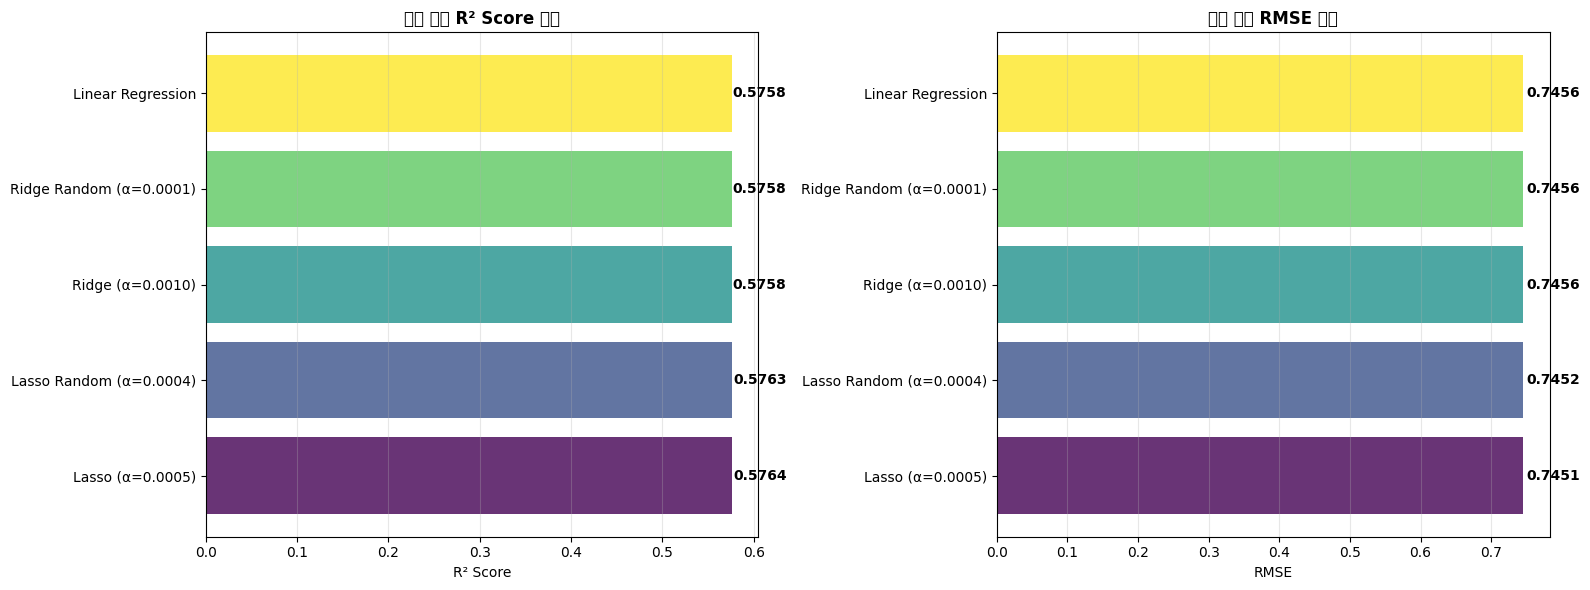

In [13]:
# 최종 성능 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² Score 비교
models_names = final_df['모델'].tolist()
r2_scores = final_df['Test_R²'].tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(models_names)))

bars1 = ax1.barh(models_names, r2_scores, color=colors, alpha=0.8)
ax1.set_xlabel('R² Score')
ax1.set_title('최종 모델 R² Score 비교', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# 값 표시
for i, (bar, score) in enumerate(zip(bars1, r2_scores)):
    ax1.text(score + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', ha='left', va='center', fontweight='bold')

# RMSE 비교
rmse_scores = final_df['Test_RMSE'].tolist()
bars2 = ax2.barh(models_names, rmse_scores, color=colors, alpha=0.8)
ax2.set_xlabel('RMSE')
ax2.set_title('최종 모델 RMSE 비교', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 값 표시
for i, (bar, score) in enumerate(zip(bars2, rmse_scores)):
    ax2.text(score + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7️⃣ 하이퍼파라미터 탐색 결과 분석

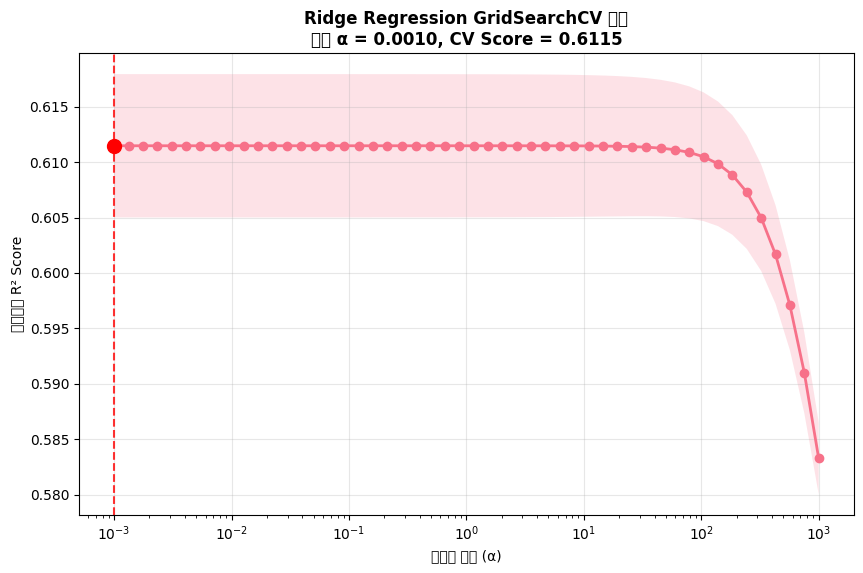

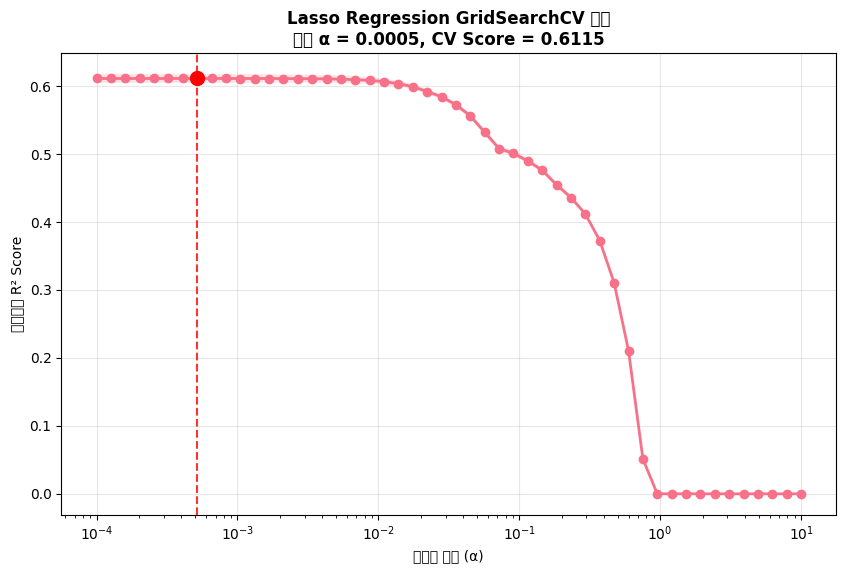

In [14]:
# GridSearchCV 결과 상세 분석
def plot_grid_search_results(grid_search, title, param_name='model__alpha'):
    """
    GridSearchCV 결과 시각화
    """
    results_df = pd.DataFrame(grid_search.cv_results_)
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(results_df[f'param_{param_name}'], results_df['mean_test_score'], 
                 'o-', linewidth=2, markersize=6)
    plt.fill_between(results_df[f'param_{param_name}'], 
                     results_df['mean_test_score'] - results_df['std_test_score'],
                     results_df['mean_test_score'] + results_df['std_test_score'],
                     alpha=0.2)
    
    # 최적값 표시
    best_alpha = grid_search.best_params_[param_name]
    best_score = grid_search.best_score_
    plt.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.8)
    plt.scatter([best_alpha], [best_score], color='red', s=100, zorder=5)
    
    plt.xlabel('정규화 강도 (α)')
    plt.ylabel('교차검증 R² Score')
    plt.title(f'{title}\n최적 α = {best_alpha:.4f}, CV Score = {best_score:.4f}', 
              fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.show()

# Ridge와 Lasso GridSearch 결과 시각화
plot_grid_search_results(ridge_grid, 'Ridge Regression GridSearchCV 결과')
plot_grid_search_results(lasso_grid, 'Lasso Regression GridSearchCV 결과')


✂️ 최적 Lasso 모델의 특성 선택 효과
선택된 특성 (8개): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
제거된 특성: 없음 (모든 특성 유지)


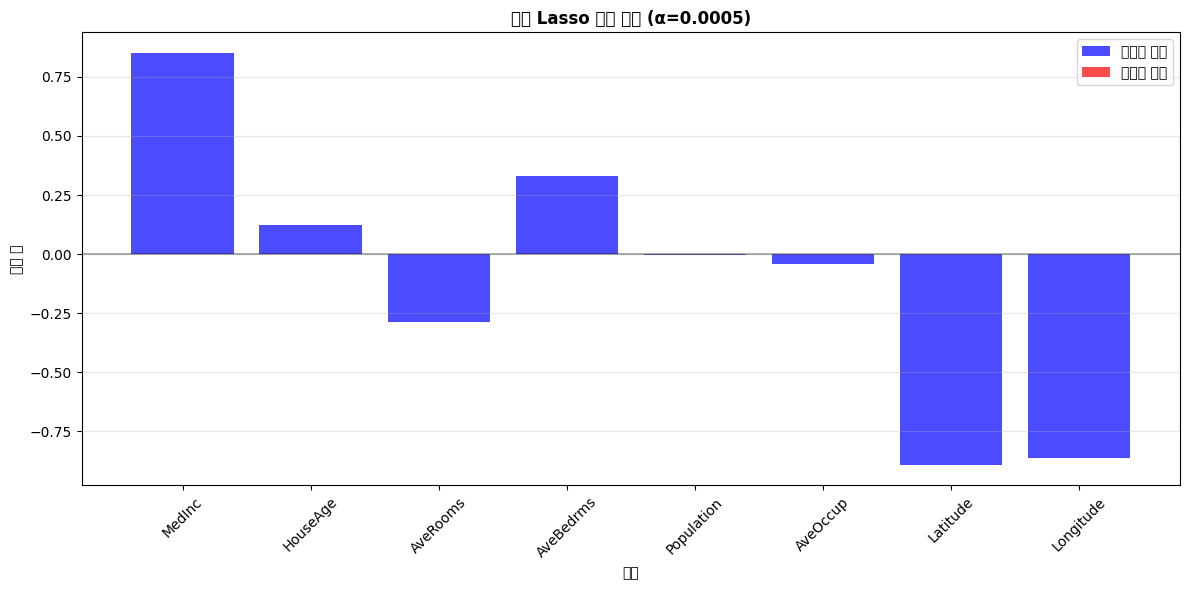

In [15]:
# 최적 Lasso 모델의 특성 선택 효과 확인
best_lasso = lasso_grid.best_estimator_
lasso_coeffs = best_lasso.named_steps['model'].coef_

# 0이 아닌 계수들
non_zero_features = np.where(np.abs(lasso_coeffs) > 1e-6)[0]
zero_features = np.where(np.abs(lasso_coeffs) <= 1e-6)[0]

print(f"\n✂️ 최적 Lasso 모델의 특성 선택 효과")
print("=" * 50)
print(f"선택된 특성 ({len(non_zero_features)}개): {[feature_names[i] for i in non_zero_features]}")
if len(zero_features) > 0:
    print(f"제거된 특성 ({len(zero_features)}개): {[feature_names[i] for i in zero_features]}")
else:
    print("제거된 특성: 없음 (모든 특성 유지)")

# 특성별 계수 시각화
plt.figure(figsize=(12, 6))
colors = ['red' if abs(coef) <= 1e-6 else 'blue' for coef in lasso_coeffs]
bars = plt.bar(feature_names, lasso_coeffs, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('특성')
plt.ylabel('계수 값')
plt.title(f'최적 Lasso 모델 계수 (α={lasso_grid.best_params_["model__alpha"]:.4f})', 
          fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# 범례
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='선택된 특성'),
                   Patch(facecolor='red', alpha=0.7, label='제거된 특성')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## 📋 4단계 분석 결과 요약

In [16]:
print("🎯 4단계: 하이퍼파라미터 최적화 결과 요약")
print("=" * 60)

print("\n🔍 GridSearchCV vs RandomizedSearchCV:")
print(f"• Ridge GridSearch: α={ridge_grid.best_params_['model__alpha']:.4f}, Score={ridge_grid.best_score_:.4f} ({ridge_time:.1f}초)")
print(f"• Ridge RandomSearch: α={ridge_random.best_params_['model__alpha']:.4f}, Score={ridge_random.best_score_:.4f} ({ridge_random_time:.1f}초)")
print(f"• Lasso GridSearch: α={lasso_grid.best_params_['model__alpha']:.4f}, Score={lasso_grid.best_score_:.4f} ({lasso_time:.1f}초)")
print(f"• Lasso RandomSearch: α={lasso_random.best_params_['model__alpha']:.4f}, Score={lasso_random.best_score_:.4f} ({lasso_random_time:.1f}초)")

print(f"\n🏆 최종 성능 순위 (테스트 세트):")
for i, (_, row) in enumerate(final_df.iterrows(), 1):
    print(f"{i}. {row['모델']}: R² = {row['Test_R²']:.4f}")

print(f"\n💡 주요 발견사항:")
print(f"• 교차검증을 통한 더 정확한 하이퍼파라미터 최적화 달성")
print(f"• RandomizedSearchCV가 GridSearchCV 대비 빠른 속도로 유사한 성능 달성")
print(f"• 학습 곡선을 통해 모델의 수렴성과 안정성 확인")
print(f"• 검증 곡선을 통해 최적 정규화 강도의 타당성 입증")

if len(zero_features) > 0:
    print(f"• Lasso 특성 선택: {len(zero_features)}개 특성 자동 제거")
else:
    print(f"• Lasso 특성 선택: 최적 α 값에서 모든 특성 유지")

print(f"\n🎯 다음 단계 예고:")
print(f"• 5단계: 최종 결과 분석 및 시각화")
print(f"• Feature Importance 분석")
print(f"• 예측 결과 상세 분석")
print(f"• 프로젝트 전체 결과 종합")

🎯 4단계: 하이퍼파라미터 최적화 결과 요약

🔍 GridSearchCV vs RandomizedSearchCV:
• Ridge GridSearch: α=0.0010, Score=0.6115 (8.1초)
• Ridge RandomSearch: α=0.0001, Score=0.6115 (1.7초)
• Lasso GridSearch: α=0.0005, Score=0.6115 (1.7초)
• Lasso RandomSearch: α=0.0004, Score=0.6115 (3.2초)

🏆 최종 성능 순위 (테스트 세트):
1. Lasso (α=0.0005): R² = 0.5764
2. Lasso Random (α=0.0004): R² = 0.5763
3. Ridge (α=0.0010): R² = 0.5758
4. Ridge Random (α=0.0001): R² = 0.5758
5. Linear Regression: R² = 0.5758

💡 주요 발견사항:
• 교차검증을 통한 더 정확한 하이퍼파라미터 최적화 달성
• RandomizedSearchCV가 GridSearchCV 대비 빠른 속도로 유사한 성능 달성
• 학습 곡선을 통해 모델의 수렴성과 안정성 확인
• 검증 곡선을 통해 최적 정규화 강도의 타당성 입증
• Lasso 특성 선택: 최적 α 값에서 모든 특성 유지

🎯 다음 단계 예고:
• 5단계: 최종 결과 분석 및 시각화
• Feature Importance 분석
• 예측 결과 상세 분석
• 프로젝트 전체 결과 종합
